# Exercício 1

Consider a database and a classification problem. Apply leave-one-out multi-fold cross-validation explained in section 8.5 of [4], with K = 4, for a MLP model. Use the facilities available in libraries for neural network implementation, like Keras, Tensor flow, scikit-learn, Matlab, etc. [7].
OBS: For image databases, convert each image to grayscale and use the image histogram for feature
extraction.

(a) Show the graphical representation of the evolution of training and validation stages (see Figure
8.8 of the course monograph).

(b) Perform a statistical analysis of the performance (section 8.6) of the four models applied over
the Dte.

(c) Analyze the influence of optimizer hyperparameters

### Importando dados

Vamos importar o dataset cifar10 do keras que é um dataset composto de 50.000 imagens coloridas de 32x32 pixels classificadas em 10 classes. Essas imagens são compostas por: \
0	airplane\
1	automobile\
2	bird\
3	cat\
4	deer\
5	dog\
6	frog\
7	horse\
8	ship\
9	truck

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Carregar o dataset MNIST
(x1, y1), (x2, y2) = fashion_mnist.load_data()

# Concatenar os dados de treino e teste
x_all = np.concatenate((x1, x2,), axis=0)
y_all = np.concatenate((y1, y2), axis=0)

2024-08-09 09:59:57.329644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 09:59:57.549349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 09:59:57.634324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 09:59:57.658467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 09:59:57.801130: I tensorflow/core/platform/cpu_feature_guar

Plotando imagem exemplo:

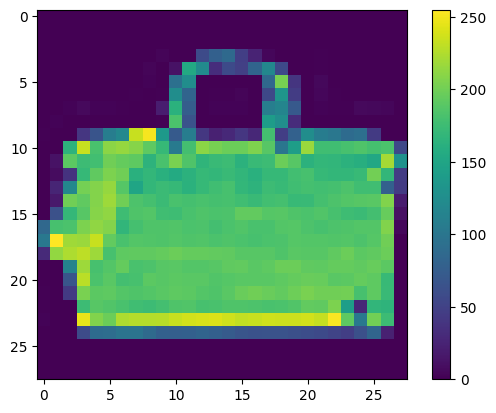

In [2]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_all[99])
plt.colorbar()
plt.grid(False)
plt.show()

In [3]:
# transformando imagens em vetores
x_all_flat = x_all.reshape(x_all.shape[0], -1)
x_all_flat.shape

(70000, 784)

Dividindo conjunto de dados:

In [4]:
# Dividir os dados em treino e teste conforme a proporção desejada
x, x_test, y, y_test = train_test_split(
    x_all_flat, y_all, test_size=0.2, random_state=42
)

In [5]:
len(x)

56000

Exibindo o histograma sobre o número de cada tipo de imagem:

In [6]:
import numpy as np
import matplotlib.pyplot as plt

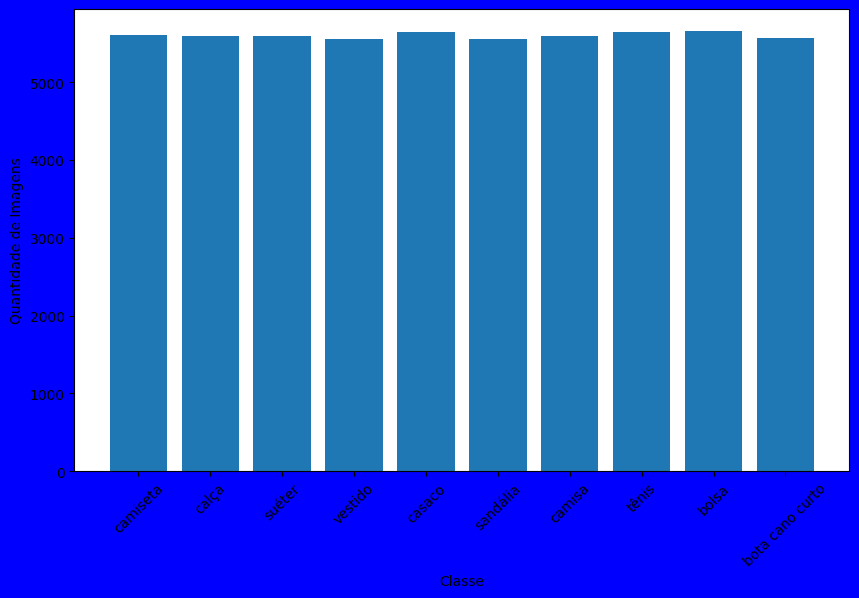

In [10]:
# Contar a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotar o histograma
class_names = ['camiseta', 'calça', 'suéter', 'vestido', 'casaco', 'sandália', 'camisa', 'tênis', 'bolsa', 'bota cano curto']

plt.figure(figsize=(10, 6), facecolor='blue', edgecolor='black')
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()


Normalizando o conjunto de dados:

In [11]:
x = x / 255.0
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
x_test = x_test / 255.0
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Começando a construção do modelo:

In [13]:
from keras.layers import Dense,Dropout
from keras.models import Sequential

Adicionando camadas:

In [14]:
def create_model():
    model = Sequential()
    model.add(Dense(units=512,input_dim=784, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=10, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # compile configura o modelo para o treinamento

    return model

In [16]:
# Definir o número de folds
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Listas para armazenar os históricos e as pontuações de cada fold
histories = []

# Lista para armazenar cada modelo
models = []

# Executar a validação cruzada
for fold, (train_index, val_index) in enumerate(kf.split(x)):
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Criar e treinar o modelo
    model = create_model()
    history = model.fit(x_train, y_train, epochs=20, batch_size=32,
                        validation_data=(x_val, y_val), verbose=1)
    
    models.append(model)
    
    # Armazenar o histórico do fold
    histories.append(history.history)
    
    # Avaliar e exibir a pontuação
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Fold {fold + 1} - Acurácia: {score[1]:.4f}')

Epoch 1/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6835 - loss: 0.8776 - val_accuracy: 0.8380 - val_loss: 0.4453
Epoch 2/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8086 - loss: 0.5353 - val_accuracy: 0.8490 - val_loss: 0.4014
Epoch 3/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8261 - loss: 0.4841 - val_accuracy: 0.8563 - val_loss: 0.4036
Epoch 4/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8362 - loss: 0.4571 - val_accuracy: 0.8652 - val_loss: 0.3696
Epoch 5/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8419 - loss: 0.4463 - val_accuracy: 0.8619 - val_loss: 0.3784
Epoch 6/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8472 - loss: 0.4218 - val_accuracy: 0.8711 - val_loss: 0.3582
Epoch 7/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8463 - loss: 0.4276 - val_accuracy: 0.8619 - val_loss: 0.3668
Epoch 8/20
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8501 - loss: 0.4

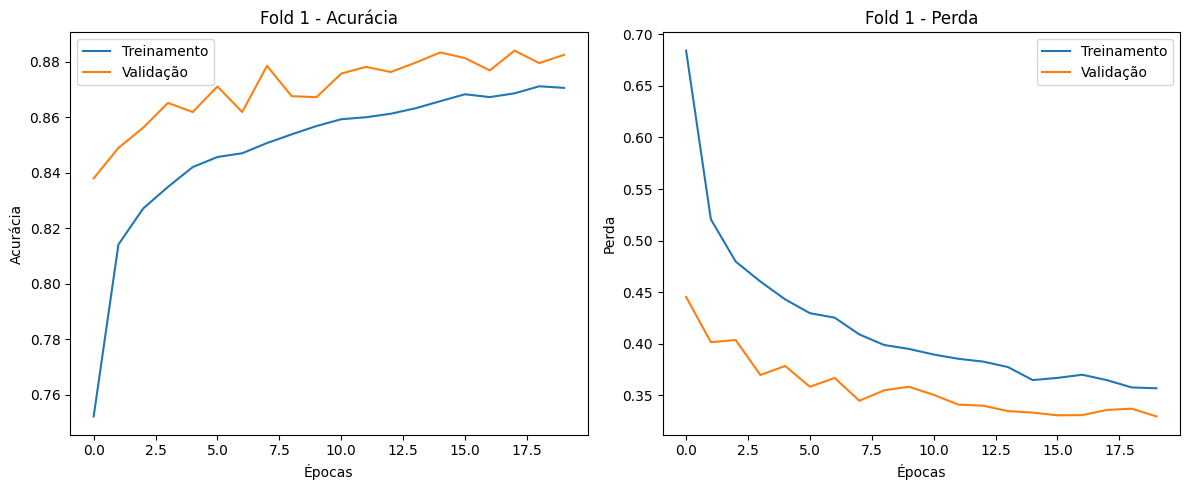

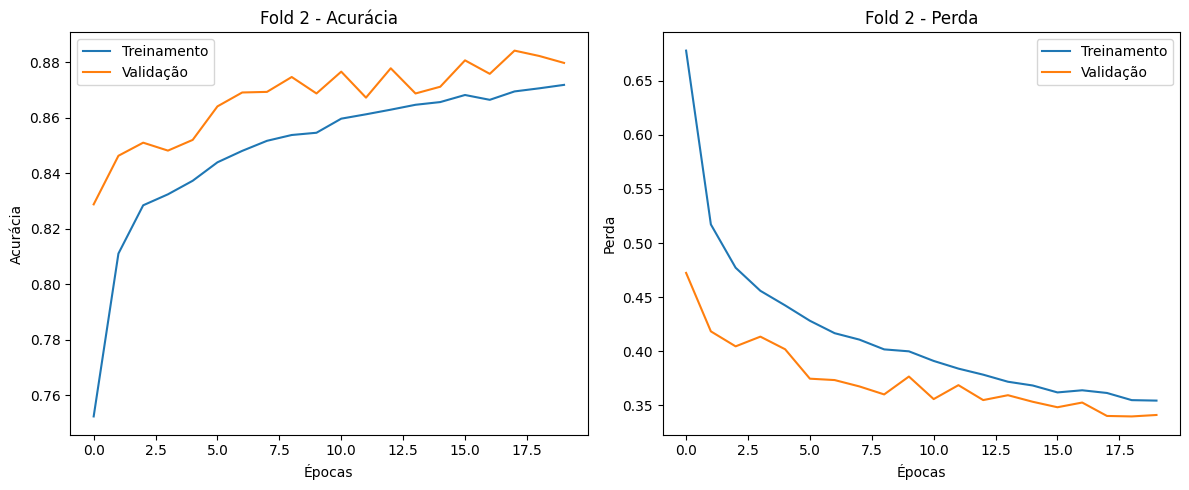

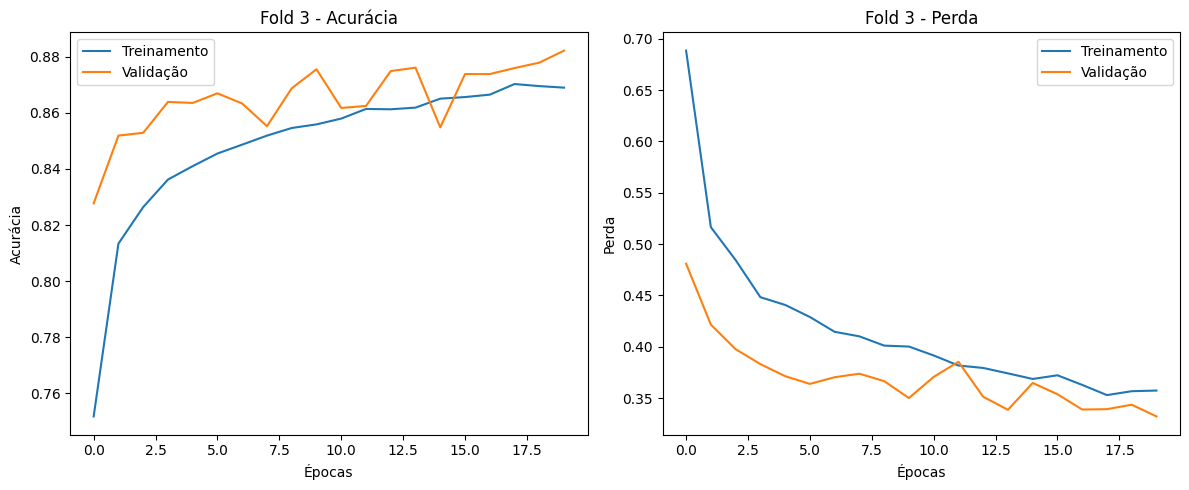

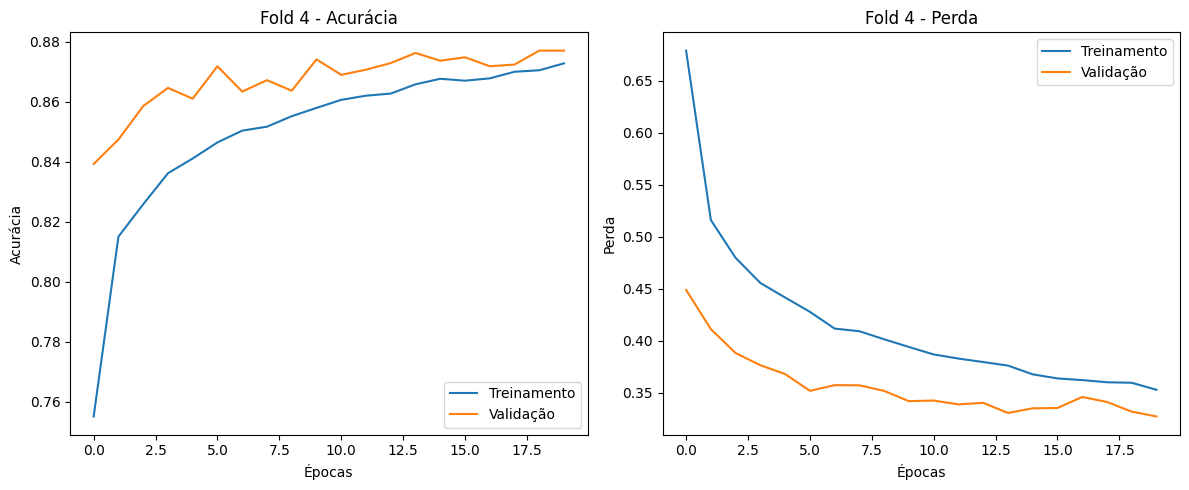

In [17]:
# Plotar gráficos de acurácia e perda para cada fold
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    # Plotar acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Treinamento')
    plt.plot(history['val_accuracy'], label='Validação')
    plt.title(f'Fold {fold + 1} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Fold {fold + 1} - Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Salvando modelos


In [23]:
for i,mod in enumerate(models):
    mod.save(f'./modelos/mod{i}.keras')

Carregando e testando:

In [25]:
import keras
Kfold1 = keras.models.load_model('./modelos/mod0.keras')

In [26]:
resK1 = Kfold1.evaluate(x_test, y_test)
print('Loss:', resK1[0])
print('Accuracy:', resK1[1])

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8860 - loss: 0.3257
Loss: 0.32861223816871643
Accuracy: 0.8851428627967834


Avaliando cada modelo:

In [19]:
for mod in models:
    res = mod.evaluate(x_test, y_test)
    print('Loss:', res[0])
    print('Accuracy:', res[1])

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8860 - loss: 0.3257
Loss: 0.32861223816871643
Accuracy: 0.8851428627967834
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8828 - loss: 0.3257
Loss: 0.32863950729370117
Accuracy: 0.8837142586708069
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8905 - loss: 0.3177
Loss: 0.3233182430267334
Accuracy: 0.888785719871521
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8868 - loss: 0.3192
Loss: 0.32608598470687866
Accuracy: 0.8837857246398926


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


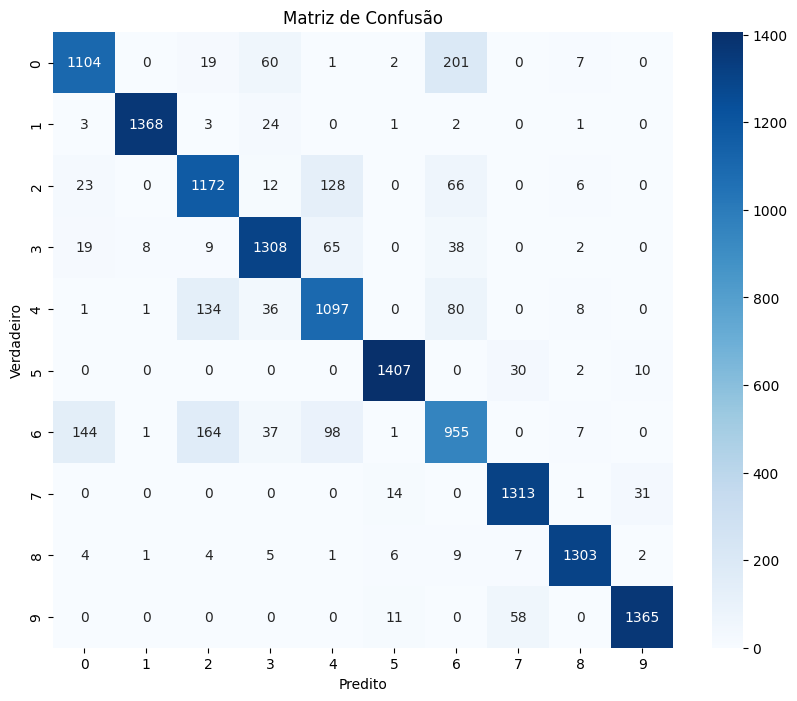

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1394
           1       0.99      0.98      0.98      1402
           2       0.78      0.83      0.80      1407
           3       0.88      0.90      0.89      1449
           4       0.79      0.81      0.80      1357
           5       0.98      0.97      0.97      1449
           6       0.71      0.68      0.69      1407
           7       0.93      0.97      0.95      1359
           8       0.97      0.97      0.97      1342
           9       0.97      0.95      0.96      1434

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.88     14000
weighted avg       0.89      0.89      0.88     14000

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


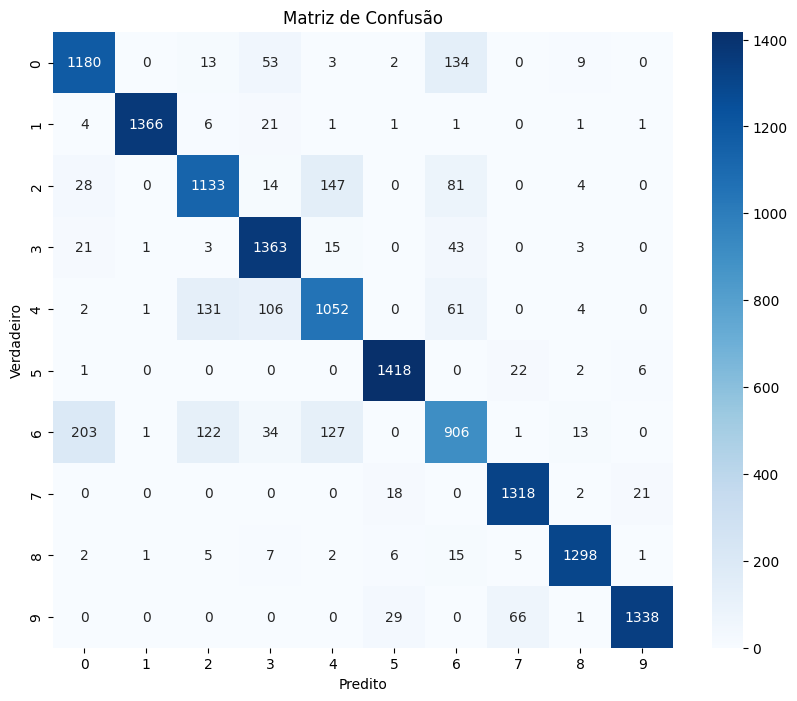

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1394
           1       1.00      0.97      0.99      1402
           2       0.80      0.81      0.80      1407
           3       0.85      0.94      0.89      1449
           4       0.78      0.78      0.78      1357
           5       0.96      0.98      0.97      1449
           6       0.73      0.64      0.68      1407
           7       0.93      0.97      0.95      1359
           8       0.97      0.97      0.97      1342
           9       0.98      0.93      0.96      1434

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


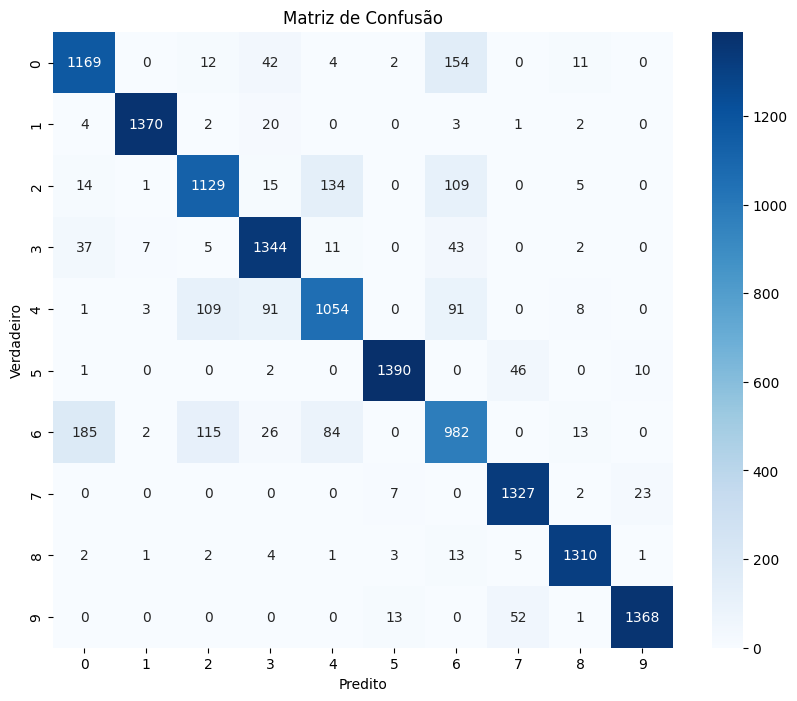

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1394
           1       0.99      0.98      0.98      1402
           2       0.82      0.80      0.81      1407
           3       0.87      0.93      0.90      1449
           4       0.82      0.78      0.80      1357
           5       0.98      0.96      0.97      1449
           6       0.70      0.70      0.70      1407
           7       0.93      0.98      0.95      1359
           8       0.97      0.98      0.97      1342
           9       0.98      0.95      0.96      1434

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


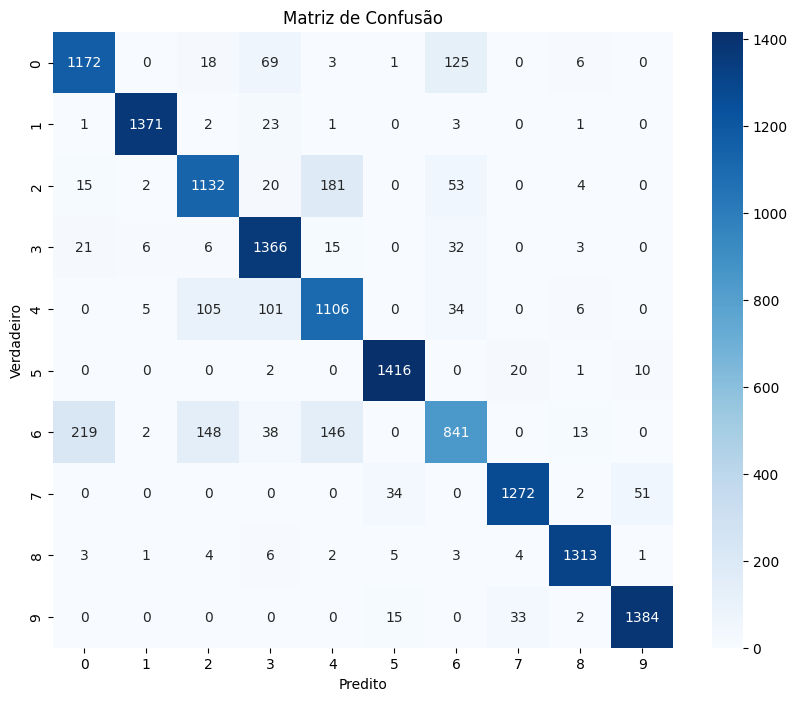

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1394
           1       0.99      0.98      0.98      1402
           2       0.80      0.80      0.80      1407
           3       0.84      0.94      0.89      1449
           4       0.76      0.82      0.79      1357
           5       0.96      0.98      0.97      1449
           6       0.77      0.60      0.67      1407
           7       0.96      0.94      0.95      1359
           8       0.97      0.98      0.98      1342
           9       0.96      0.97      0.96      1434

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

for md in models:
    y_pred = md.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes
    #y_true = np.argmax(y_test, axis=1)  # Converter one-hot para classes

    # Criar a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Visualizar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

    # Calcular e imprimir o relatório de classificação
    report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(10)])
    print(report)
